In [1]:
!pip install scanpy scvi-tools scrublet igraph louvain leidenalg


  Using cached scanpy-1.11.1-py3-none-any.whl.metadata (9.9 kB)
  Using cached scvi_tools-1.3.0-py3-none-any.whl.metadata (19 kB)
  Using cached scrublet-0.2.3-py3-none-any.whl.metadata (3.1 kB)
  Using cached igraph-0.11.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached louvain-0.8.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached anndata-0.11.4-py3-none-any.whl.metadata (9.3 kB)
  Using cached legacy_api_wrap-1.4.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached session_info2-0.1.2-py3-none-any.whl.metadata (2.5 kB)
  Using cached docrep-0.3.2.tar.gz (33 kB)
  Preparing metadata (setup.py) ... done
  Using cached jax-0.4.35-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.35

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import scanpy as sc
import scvi
import numpy as np
import scrublet as scr
import os


/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [4]:
adata_atrium = sc.read_10x_mtx(
    "/content/drive/MyDrive/Cellranger/GSM8147512_atrium_mine/filtered_feature_bc_matrix",
    var_names="gene_symbols",
    make_unique=True
)

adata_heart = sc.read_10x_mtx(
    "/content/drive/MyDrive/Cellranger/GSM8147511_wholeheart_mine/filtered_feature_bc_matrix",
    var_names="gene_symbols",
    make_unique=True
)


In [5]:
adata_atrium.obs["sample"] = "atrium"
adata_heart.obs["sample"] = "heart"


In [6]:
common_genes = adata_atrium.var_names.intersection(adata_heart.var_names)
adata_atrium = adata_atrium[:, common_genes]
adata_heart = adata_heart[:, common_genes]


In [7]:
adata = adata_atrium.concatenate(adata_heart, batch_key="origin", batch_categories=["atrium", "heart"])


<ipython-input-7-63f78e9e0fde>:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_atrium.concatenate(adata_heart, batch_key="origin", batch_categories=["atrium", "heart"])


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

adata = adata[adata.obs.n_genes_by_counts.between(200, 5000), :]
adata = adata[adata.obs.pct_counts_mt < 5, :]


In [9]:
scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

adata = adata[~adata.obs['predicted_doublet'], :]


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 46.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.7%
Elapsed time: 39.0 seconds


<ipython-input-9-308219997e2e>:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = doublet_scores


In [10]:
adata = adata.copy()


In [11]:
scvi.model.SCVI.setup_anndata(adata)
model = scvi.model.SCVI(adata)
model.train()


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


<ipython-input-12-7c6d4aa26fc6>:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


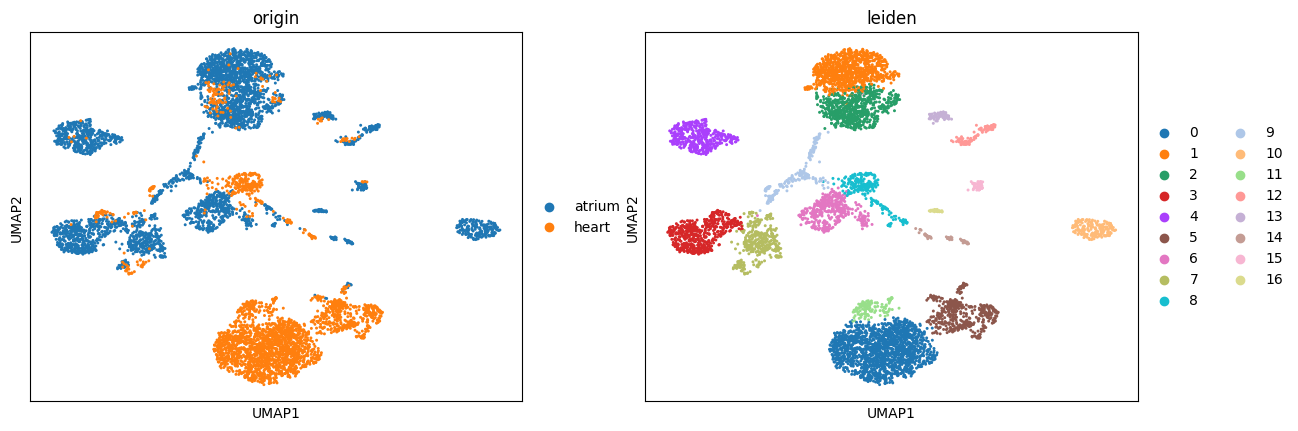

In [12]:
adata.obsm["X_scVI"] = model.get_latent_representation()

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

sc.pl.umap(adata, color=["origin", "leiden"])


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Define gene categories
housekeeping_genes = ["actb1", "gapdh", "rpl13a", "eef1a1l1", "b2m", "hmbs", "rplp0", "rps18", "ubqln1", "hprt1",
                      "pgk1", "tbp", "rpl19", "rpl32", "rps29", "rps27a", "rpl11", "rpl7", "rpl23a", "rps9"]

heart_genes = ["myl7", "tnnt2a", "kdrl", "fli1a", "vmhc", "amhc", "nkx2.5", "gata4", "tbx5", "actc1a",
               "tnni2a", "myh6", "myh7", "notch1b", "vegfa", "cdh5", "epas1b", "tal1", "tek", "bmp4"]

neuronal_genes = ["elavl3", "elavl4", "vim", "calm1a", "gap43", "syt1a", "tac3a", "stmn2a", "tubb5", "prph",
                  "stmn4l", "hbegfa", "calm3b", "ascl1a", "vat1", "nos1", "atp6v1e1b", "anxa13l", "stmn2b",
                  "anxa5b", "dbn1", "anxa4", "stmn4", "sox11b", "calm3a", "cnp", "calb1", "stat1a", "mycbp2",
                  "dpysl3", "cdh2", "dll4", "sv2a", "calb2a", "ddc", "sncb", "fhl1b", "rtn4b", "chata", "chrna5",
                  "sox2", "slc29a4", "slc18a3a", "galnt1", "dab2ipa", "insm1a", "ncaldb", "bmpr2a", "apc",
                  "ing2", "plxna4", "pcna", "tbh1a", "adra2a", "nell2b", "cald1b", "slc44a2", "slc5a7a", "nrgna", "plp1b"]

neurotransmitter_genes = ["chrna5", "htr1fa", "ptk2bb", "grid2", "grm1a", "gria2a", "glrbb", "chrna3", "chrnb4",
                          "chrm2a", "gria3b", "grid1b", "gabrg2", "glra1", "chrm4a", "gabra6b", "gabbr1a", "chrna1",
                          "gria4b", "glra4a", "grik4", "gabrg3", "adrb1", "chrm1b", "chrnb1", "chrne", "chrng",
                          "drd1a", "drd5a", "gabra6a", "gabrr2a", "gabrr3a", "glra2", "glra3", "gpr158a", "gpr158b",
                          "gria1a", "grik1a", "grik5", "grin1a", "grin1b", "grin2bb", "grin2da", "grin3a", "grin3bb",
                          "hrh3", "htr1ab", "htr1b", "htr2aa", "htr2b", "htr2cl1", "htr3a", "htr4", "htr6", "htr7c",
                          "ptk2ba"]


In [14]:
def get_valid_genes(adata, gene_list):
    return [gene for gene in gene_list if gene in adata.var_names]

valid_neuronal = get_valid_genes(adata, neuronal_genes)
valid_neurotransmitter = get_valid_genes(adata, neurotransmitter_genes)
valid_heart = get_valid_genes(adata, heart_genes)
valid_housekeeping = get_valid_genes(adata, housekeeping_genes)


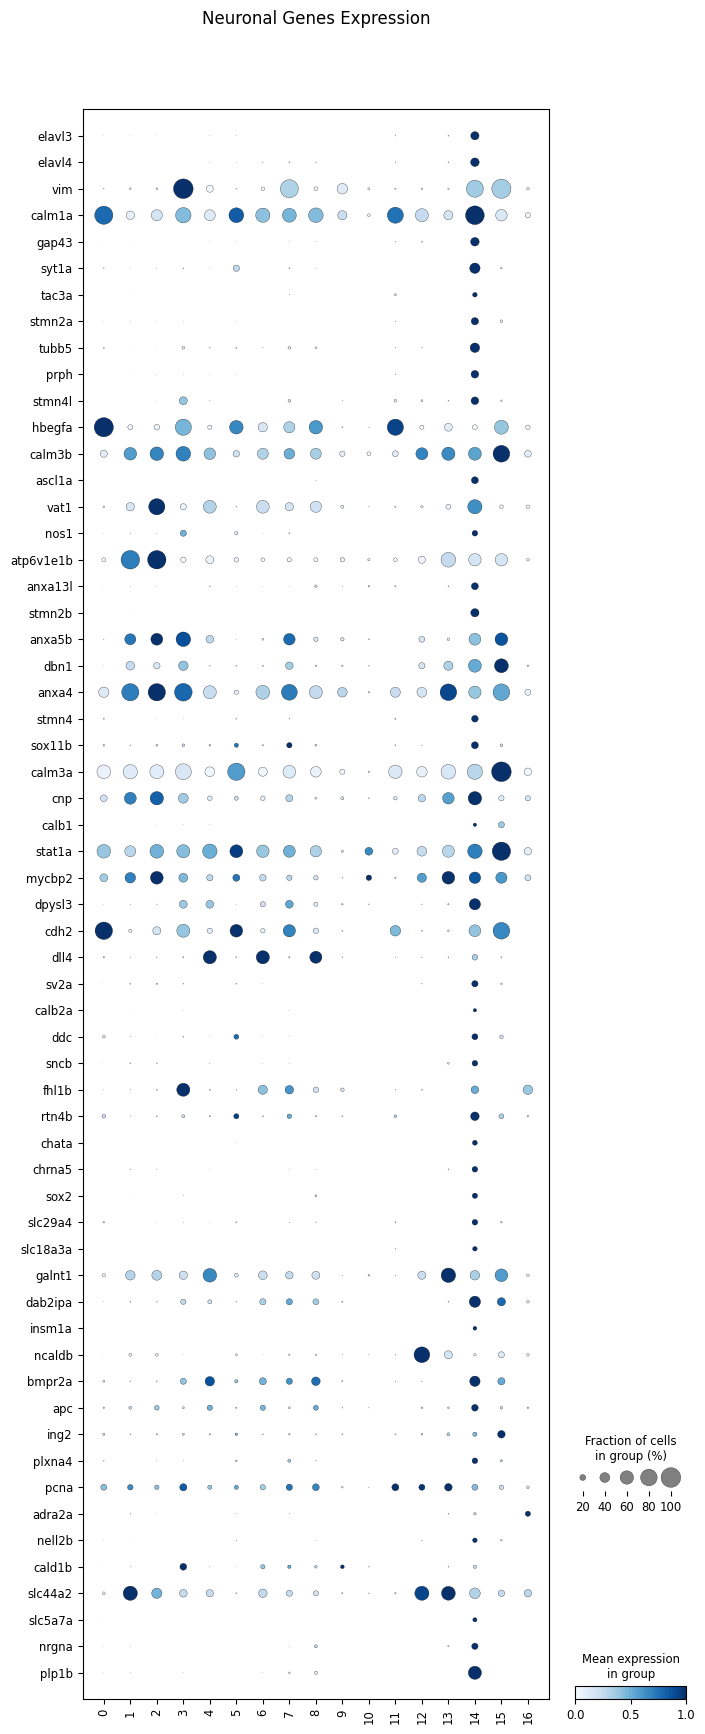

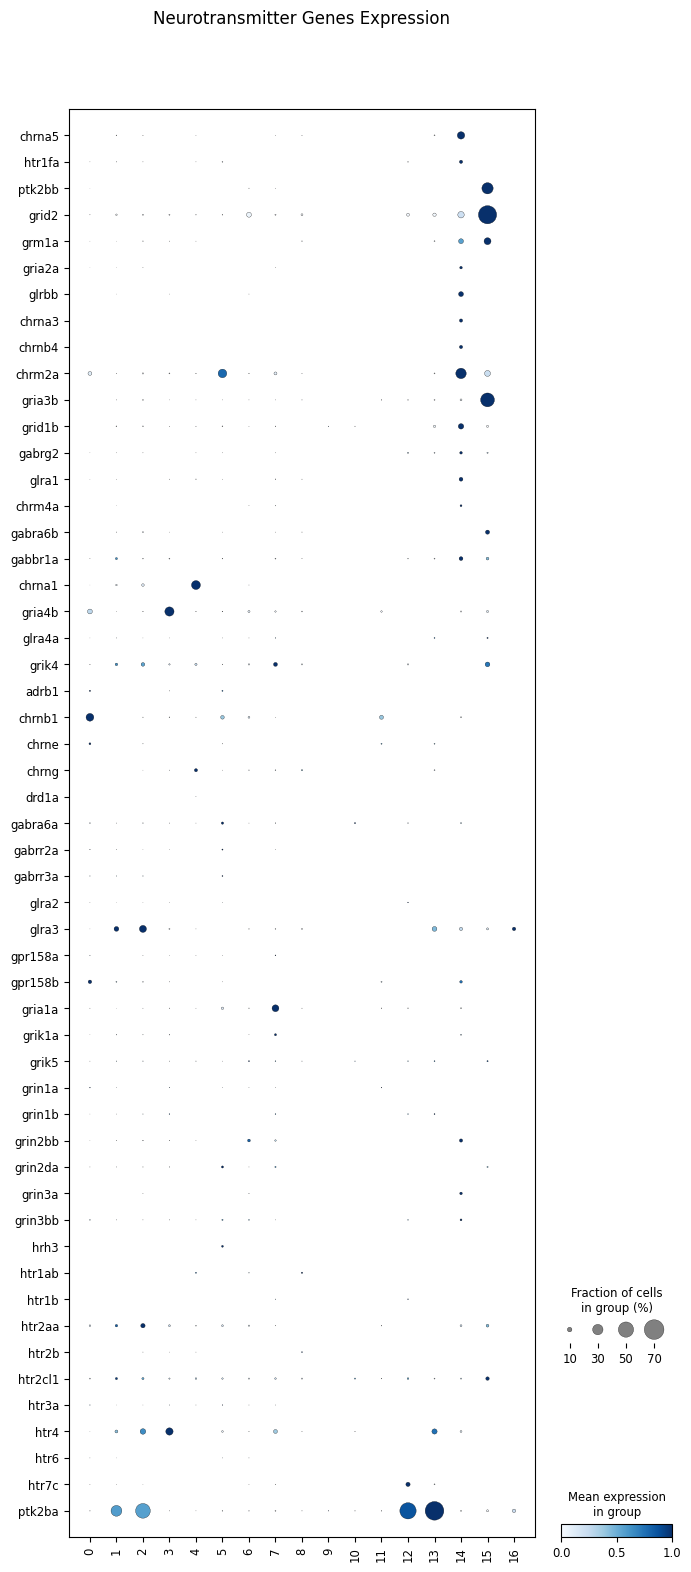

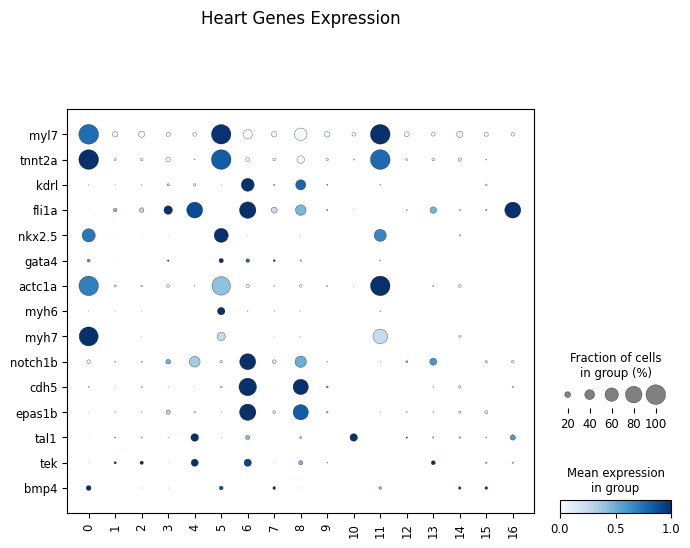

In [15]:
sc.pl.dotplot(adata, var_names=valid_neuronal, groupby="leiden", cmap="Blues", standard_scale="var", swap_axes=True, title="Neuronal Genes Expression")
sc.pl.dotplot(adata, var_names=valid_neurotransmitter, groupby="leiden", cmap="Blues", standard_scale="var", swap_axes=True, title="Neurotransmitter Genes Expression")
sc.pl.dotplot(adata, var_names=valid_heart, groupby="leiden", cmap="Blues", standard_scale="var", swap_axes=True, title="Heart Genes Expression")


<ipython-input-16-606802495c5d>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(adata.obs["leiden"]).mean()


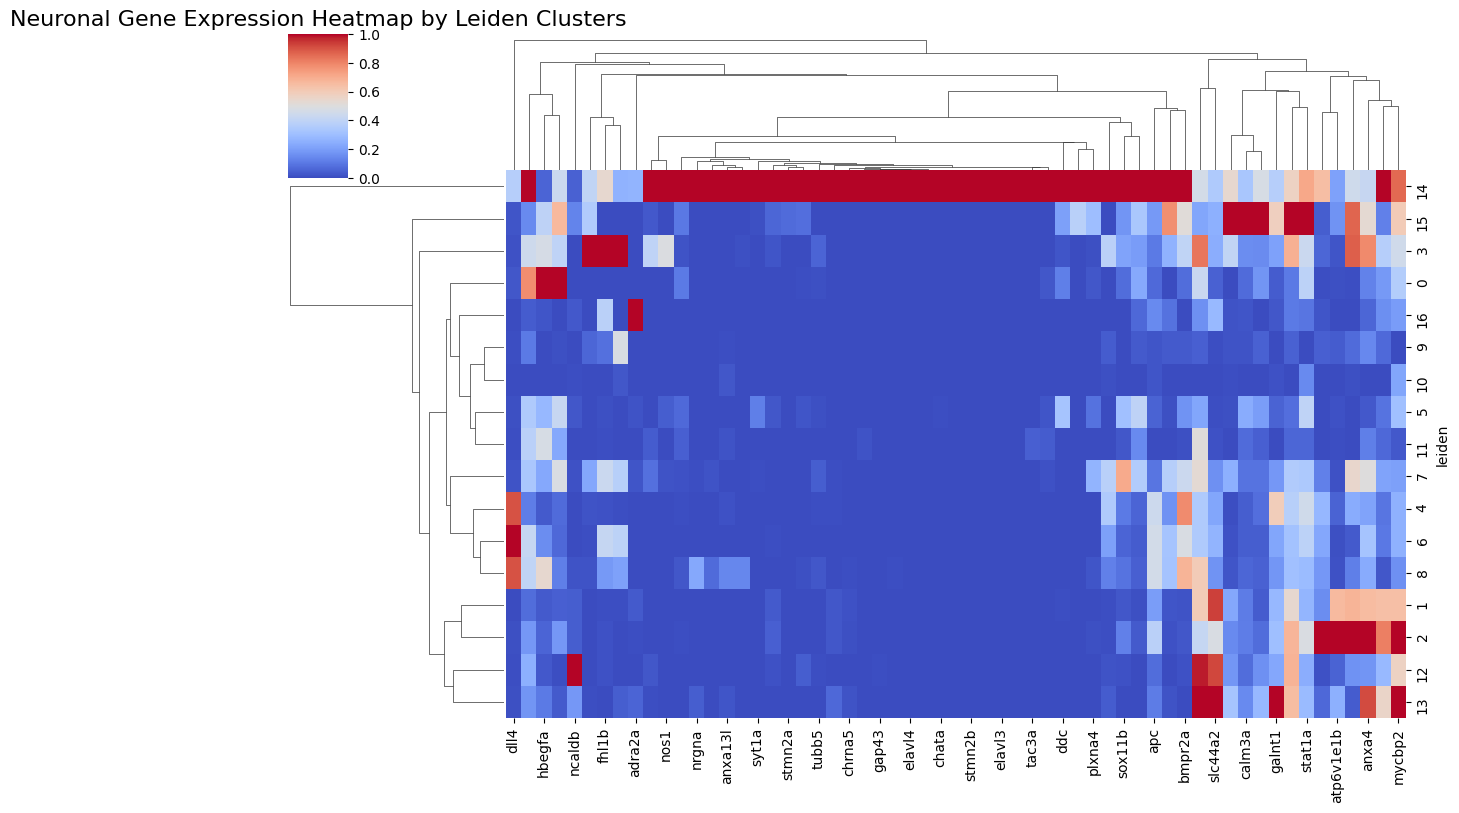

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(
    adata[:, valid_neuronal].X.toarray(),
    index=adata.obs.index,
    columns=valid_neuronal
)

df_grouped = df.groupby(adata.obs["leiden"]).mean()

sns.clustermap(
    df_grouped,
    cmap="coolwarm",
    method="average",
    metric="euclidean",
    standard_scale=1,
    figsize=(12, 8)
)
plt.title("Neuronal Gene Expression Heatmap by Leiden Clusters", fontsize=16)
plt.show()


In [17]:
adata.write("/content/drive/MyDrive/Cellranger/Merged_adata_zebrafish.h5ad")


In [18]:
adata.obs["origin"].value_counts()


,count
origin,
atrium,3927
heart,2668


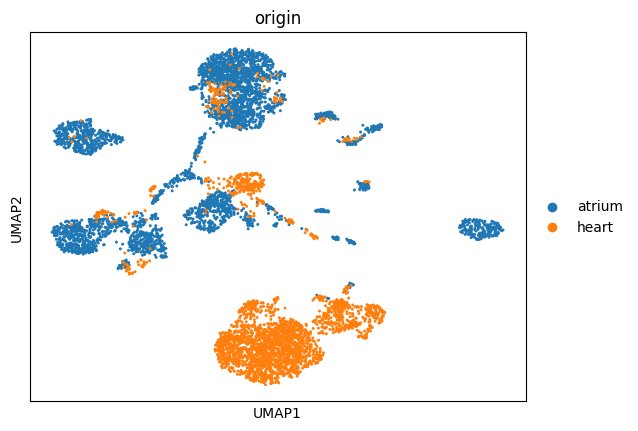

In [19]:
sc.pl.umap(adata, color="origin")
